# Recidivism in Georgia

## Introduction

The dataset used is from the american National Institute of Justice describing recidivism in the state of Georgia.[1](https://nij.ojp.gov/funding/recidivism-forecasting-challenge#19-0) The data is collected for offenders released to parole for supervision in the period 2013-2015 with recidivism information about the offenders; whether or not the offender reoffends. Where we initially choose the following as interesting attributes, e.g. omitting arrest data since we find conviction data more eligible. We mark the <span style="color:green">protected features marked in green</span> and <span style="color:red">target marked in red</span>.


We are especially interested in a model predicting recidivism. In our ethical reflections we consider two cases, the predicted risk of recidivating can be used for positive and negative effects for the offender. <br>
- **Negative:**  length of sentence and opportunity for probation. 
- **Positive:** allocation of more ressources to resociale the offender e.g. educational or employment programmes. 

In either case it is not legal to discriminate in regards to protected attributes (i.e. sex and race in this case). However we would argue that being discriminating in regards to length of sentence and opportunity for probation is more significant than being discriminating in regards to ressources when released from prison. It is also possible to view it as the first is affecting your negative liberty whereas the second affects your positive liberty. [2](https://plato.stanford.edu/entries/liberty-positive-negative/)



| # | Variable | Definition |
|---|----------|------------|
| 1 | <span style="color:green">Sex</span>  | Binary: Male/Female |
| 2 | <span style="color:green">Race</span> | Binary: Black/White* |
| 3 | Age_at_Release | Categorical: 18-22, 23-27, 28-32, 33-37, 38-42, 43-47, 48+ |
| 4 | Gang_Affiliated | Binary: True/False, verified by investigation |
| 5 | Supervision_Risk_Score_First | Scale: First Parole Supervision Risk Assessment Score (1-10, where 1=lowest risk) |
| 6 | Supervision_Level_First | Categorical: First Parole Supervision Level Assignment (Standard, High, Specialized) |
| 7 | Education_Level | Categorical: Less than High School, High School diploma, at least some college |
| 8 | Dependents | Scale: 0, 1, 2, 3+ dependents at prison entry |
| 9 | Prison_Offense | Categorical: Violent/Sex, Violent/Non-Sex, Property, Drug, Other |
| 10 | Prison_Years | Scale: <1, 1-2, 2-3, 3+. Prior to parole release. |
| 11 | Prior_Conviction_Episodes_Felony | Scale: 0, 1, 2, 3+ |
| 12 | Prior_Conviction_Episodes_Misd | Scale: 0, 1, 2, 3, 4+. Misdemeanor |
| 13 | Prior_Conviction_Episodes_Viol | Binary: True/False. Violent |
| 14 | Prior_Conviction_Episodes_Prop | Scale: 0, 1, 2, 3+. Property |
| 15 | Prior_Conviction_Episodes_Drug | Scale: 0, 1, 2+ |
| 16 | Prior_Conviction_Episodes_PPViolenceCharges | Binary: True/False. Probation/Parole violation |
| 17 | Prior_Conviction_Episodes_DomesticViolenceCharges | Binary: True/False |
| 18 | Prior_Conviction_Episodes_GunCharges | Binary: True/False |
| 19 | Condition_MH_SA | Binary: True/False. Parole Release Condition = Mental Health or Substance Abuse Programming |
| 20 | Condition_Cog_Ed | Binary: True/False. Parole Release Condition = Cognitive Skills or Education Programming |
| 21 | Condition_Other | Binary: True/False. Parole Release Condition = No Victim Contact or Electronic Monitoring or Restitution or Sex Offender Registration/Program |
| 22 | Violations_ElectronicMonitoring | Binary: True/False. |
| 23 | Violations_Instruction | Binary: True/False. Not following instructions. (Vague?) |
| 24 | Violations_FailToReport | Binary: True/False. Failure to report. (vague?) |
| 25 | Violations_MoveWithoutPermission | Binary: True/False. Moving without permission. |
| 26 | Delinquency_Reports | Scale: 0, 1, 2, 3, 4+. Number of rulebreaking during parole. |
| 27 | Program_Attendances | Scale: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10+. |
| 28 | Residence_Changes | Scale: 0, 1, 2, 3+. |
| 29 | Avg_Days_per_DrugTest | Scale: twice a day to three years |
| 30 | Drug_Tests_Positive | Binary: True/False. Substances THC, Cocaine, Meth, Other |
| 31 | Percent_Days_Employed | Scale: 0-100% |
| 32 | Jobs_Per_Year | Scale: 0, 1, 2, 3, 4, 5, 6, 7, 8 |
| 33 | Employment_Exempt | Binary: True/False |
| 34 | <span style="color:red">Recidivism</span> | Binary: True/False. Reoffend within 3 years |





\* *The data only contains individuals with the racial categories of Black and White to reduce the possibility of deductive disclosure of individuals identities. There were less than 500 individuals who were identified as Hispanic, and less than 100 individuals in each of the following categories Asian, Native American, other, and unknown; these cases were dropped from the sample to prevent inadvertent disclosure of personal Identifying information.*

We choose to group all the data for positive drug test.


Note: In the original dataset there is also a PUMA residence attribute, which could be interesting combine with supplemental data for e.g. affordability index, health or access/public transportation data.

## Thoughts for modelling

Potential modelling cases

- Classification for recidivism prediction
- Regression for supervision risk score

Methods
- Cleaning and investigating data. Avoiding data leakage
- Balance model complexity with size of data
- Trying a range of different models (Decision tree, regression, PCA and maybe SVM) using a validation set then choosing one model and finaly evaluating on a test set. 
- Evaluating accuracy and fairness metrics 


**Ethical significance of the Data**
When deciding on the use of algorithms as tools, it is valuable to assess the use from different ethical positions, as some might be more fit for the problem at hand than others. 

A Utilitarian approach commands that the use of the model maximises utility and minimises harm. In this sense, the judiciary system has to take the consequences of both the incarcerated and the general public and victims of crime into account. If for instanc
 a convicted murderer is set for probation, and it is possible to prevent another murder by denying probation, it is clear that a model that predicts higher risks can be valuable, when assesing what the right verdict is. This however becomes increasingly difficult, when weighing in more factors; what if the original crime is selling marijuana? Is it fair to restrict the autonomy of the defendant in an effort to keep them from selling drugs? It suddenly becomes unclear wether their release does more harm to their environment, than the harm that is put upon them by continued incarceration. If we consider this complexity in combination with the potential of racial bias, it becomes clear that it is hard to make a useful utilitarian assesment of the use of an AI model. 

Virtue ethics on the other hand, provides us a clearer assesment on the ethics at play in the judiciary. If we are to consider 'good deeds' as something that an admirable person would do, two primary charactaristics become clear; it is virtous to accept the consequences of ones crimes, and it would be a vice to wrongfully incarcerate someone. This approach to ethics provides a more easily applied principle to the use of algorithms in our specific case. It does however command more meta-discussion on the use of the algorithm; What vices and virtues are important in the discussion of the use of the model. Because of this, the potential use of virtue ethics in this specific context is flawed, in that it demands a deeper discussion on what virtues and vices are integral to discusison of the use. 


Because of the above, we choose to apply a deontological approach to ethics, when assesing the classification problem. By using Imannual Kant's categorical imperative, we can easily access what a maxime for the use of the algorithm commands of us. The universality in the imperative, which demands maximes that can be willed to be universal law, makes it appropriate for assesing the judiciary.

Using an algorithm to classify reoffenders from the given data, one could be (and many american states have been) tempted to use the classifiation as a way to score defendants on their probability of reoffending.[kilde]() This score could then be used to not only decide on probation and parole, but also what support systems are made available to defendants on probation or parole. The general ethical discussion of such use of AI in judiciary processes are outside the scope of this paper (**or is it??**), but if we decide to use it, we must ensure that the use of the algorithm does good ('good' here is to be understanded at a normative level). 

The use of Kant's categorical imperative demands of us, that we ask ourselves what a world where the use of the algorithm is universal looks like. Say for the sake of argument, that the algorithm is used to score defendants, as a way to decide on the accesibility of parole, and that it gives different false-positive rates, depending on the race of the defendant. Can we accept a moral maxime (in this case, one that accepts the use of the algorithm), under which black perople can be incarcerated for longer, on the basis of the colour of their skin? Quite intuitively, the answer is no. Since the role of the judiciary system is to provide justice to society, the categorical imperative shows a logical contradiction in the use of biased AI-models in Judiciary processes; in an effort to enforce justice for the general public, some are being injustifiably incarcerated. 

### Fairness metrics 

We will be using equalized odds as our fairness metric. Since we argue, that a false positive rate in this case can have a negative impact on the defendant. We will also be inspecting confusion matrices to interpret the false negative rate, as that can have an impact on citizens and society.

- TP: Defendants are correctly predicted to reoffend. 
- TN: Defendants are correctly predicted to not reoffend.
- FP: Defendants are wrongly predicted to reoffend, which negatively impact the defendant 
- FN: Defendants are wrongly predicted to not reoffend, which potentially negatively impact the citizens. 



## The COMPAS algorithm 

An analysis of a current assesment tool, COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) showed that the tool was more likely to incorrectly predicted black defendants as more likely to reoffend - and also more likely to incorrectly predict white defendets to not reoffend.[4](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) 

COMPAS is based on defendents respondings to a questionnaire. 

Forecasting showed a somewhat equal prediction rate but made mistakes different ways, as mentioned above. They also found that after controlling for prior crimes, future recidivism, age and gender, the algorithm was still biased. 



In [398]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from dython.nominal import associations # we chose pearson instead of cramer
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import scipy
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

## Dataset analysis

In [399]:
# Loading the dataset
df = pd.read_csv('exam_data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')

# Target is whether or not they reoffend
target=df['Recidivism_Within_3years']

# Protected features
grouprace=df['Race']
groupsex=df['Gender']

# Split immedeatly to avoid leaking from dataset
# First split: temporary and test set
X_temp, X_test, y_temp, y_test, grouprace_temp, grouprace_test, groupsex_temp, groupsex_test = train_test_split(
    df, target, grouprace, groupsex, test_size=0.2, random_state=22)

# Second split: splitting temp in training and validation
X_train, X_val, y_train, y_val, grouprace_train, grouprace_val, groupsex_train, groupsex_val = train_test_split(
    X_temp, y_temp, grouprace_temp, groupsex_temp, test_size=0.25, random_state=22)  # 0.25 x 0.8 = 0.2 

## Demographic of offenders

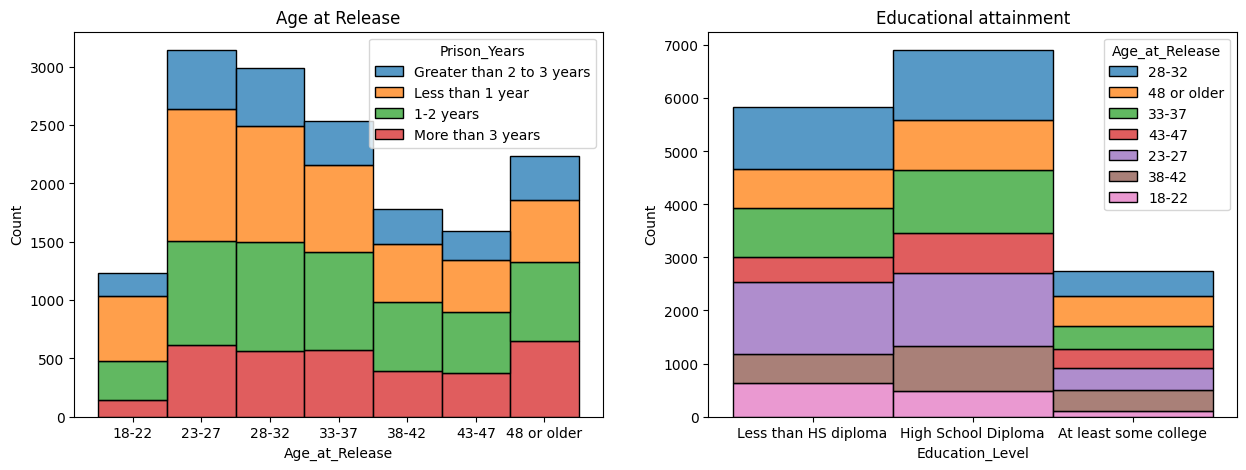

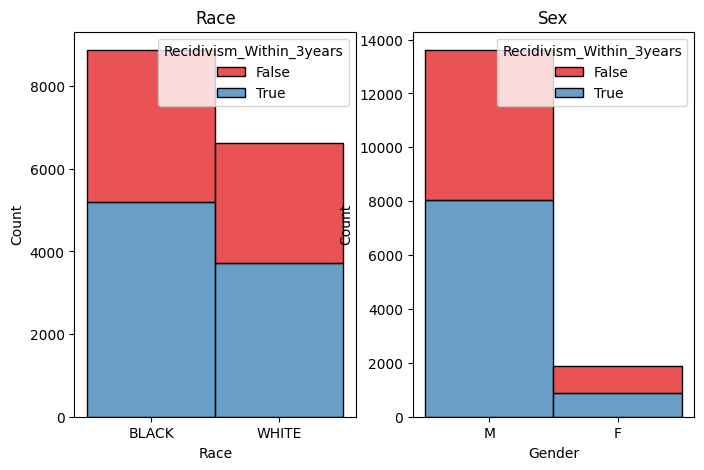

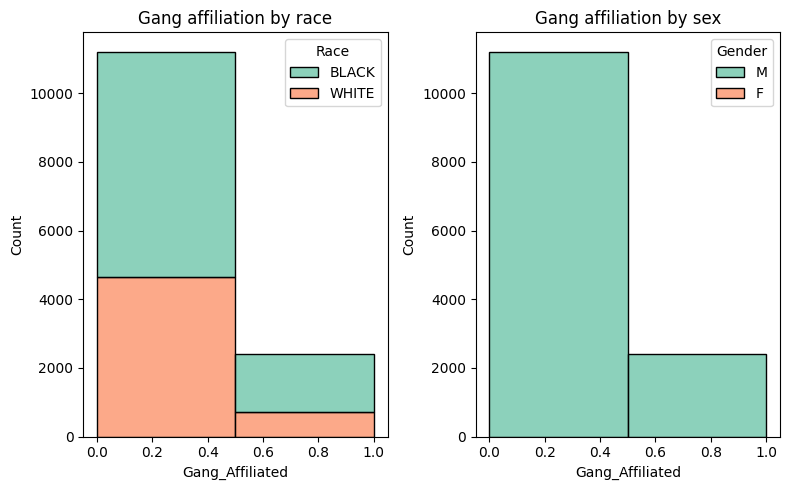

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

sns.histplot(x='Age_at_Release', data=X_train.sort_values(by='Age_at_Release'), hue='Prison_Years', bins=5, ax=axes[0], multiple='stack')
axes[0].set_title('Age at Release')

X_train['Education_Level'] = pd.Categorical(X_train['Education_Level'], ['Less than HS diploma', 'High School Diploma', 'At least some college'])
sns.histplot(data=X_train, x='Education_Level', bins=3, ax=axes[1], hue='Age_at_Release', multiple='stack')
axes[1].set_title('Educational attainment')

fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # Recidivism

sns.histplot(x='Race', data=X_train, ax=axes[0], bins=2, palette='Set1', hue='Recidivism_Within_3years', multiple='stack')
axes[0].set_title('Race')

sns.histplot(x='Gender', data=X_train, ax=axes[1], bins=2, palette='Set1', hue='Recidivism_Within_3years', multiple='stack')
axes[1].set_title('Sex')

fig, axes = plt.subplots(1, 2, figsize=(8, 5))  

sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[0], bins=2, palette='Set2', hue='Race', multiple='stack')
axes[0].set_title('Gang affiliation by race')


sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[1], bins=2, palette='Set2', hue='Gender', multiple='stack')
axes[1].set_title('Gang affiliation by sex')
# The Gang affiliation values for females are NaN!

plt.tight_layout()

In [401]:
# Chekcing for missing female gang affiliation values
print(X_train.groupby(['Gender', 'Gang_Affiliated']).size())
print(X_train.groupby(['Gender']).size())

Gender  Gang_Affiliated
M       False              11216
        True                2396
dtype: int64
Gender
F     1889
M    13612
dtype: int64


There is a majority of whites and males. 

There are no values for female gang affiliation.

## Risk score and recidivism

We are provided with a risk score, it could be interesting to investigate if there is a bias or if it's reasonably correlated with recidivism (or how violent the crime is). We see a potential for the risk score to be biased.

Text(0.5, 1.0, 'Risk score and type of offense')

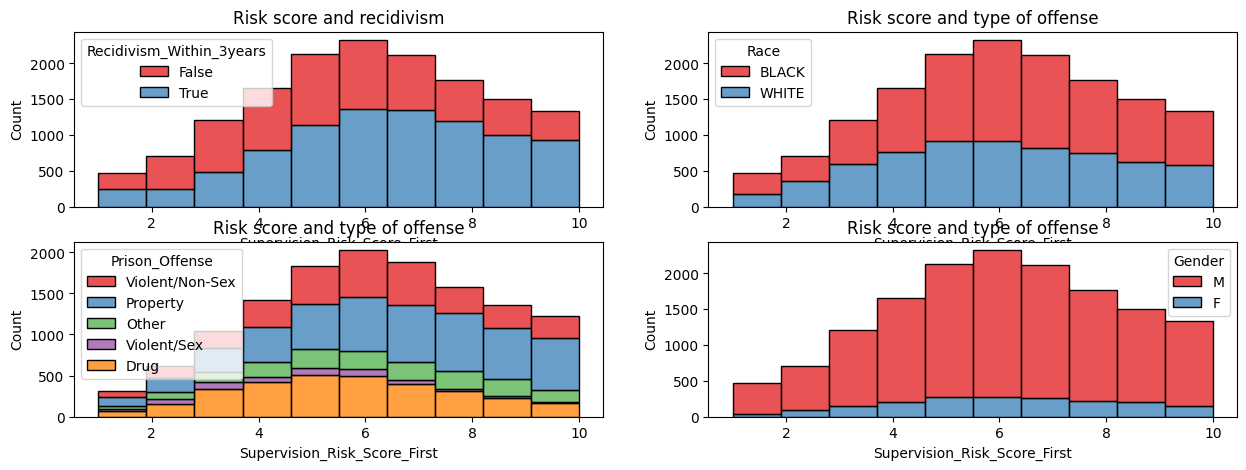

In [402]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))  

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0,0], bins=10, palette='Set1', hue='Recidivism_Within_3years', multiple='stack')
axes[0,0].set_title('Risk score and recidivism')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1,0], bins=10, palette='Set1', hue='Prison_Offense', multiple='stack')
axes[1,0].set_title('Risk score and type of offense')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0,1], bins=10, palette='Set1', hue='Race', multiple='stack')
axes[0,1].set_title('Risk score and type of offense')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1,1], bins=10, palette='Set1', hue='Gender', multiple='stack')
axes[1,1].set_title('Risk score and type of offense')


We will be dropping supervision risk score as a feature, since it is based on another classification model and we are unable to investigate what goes in to the given supervision risk score. Therefore we cannot guarantee that it is unbiased.

## Preprocessing
### Dropping and grouping columns

In [403]:
def preprocess_data(df):
    df_processed = df.copy()
    # Grouping drug data
    df_processed['DrugTest_Positive']=df_processed[['DrugTests_THC_Positive',
        'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
        'DrugTests_Other_Positive']].any(axis=1)

    # Changing age scale categories to numerical data
    df_processed['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
    df_processed['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
    df_processed['Education_Level']=df['Education_Level'].replace(['Less than HS diploma','High School Diploma', 'At least some college'], [1,2,3])
    df_processed['Prison_Years']=df['Prison_Years'].replace(['Less than 1 year','1-2 years','Greater than 2 to 3 years','More than 3 years'],[1,2,3,4])

    # Representing the groups as binary, and renaming gender to sex (since the correct class in this case is sex)
    df_processed['Race']=df['Race'].replace(['WHITE','BLACK'],[1,0])
    df_processed['Sex']=df['Gender'].replace(['M','F'],[1,0])

    
    ## Handling NaN values
    # Assuming no information of gang affiliation equals no gang affiliation
    df_processed['Gang_Affiliated']=df['Gang_Affiliated'].fillna(0).astype(int)

    # Assuming no information of supervision risk score/level means no risk (will be dropped)
    #df_processed['Supervision_Risk_Score_First']=df['Supervision_Risk_Score_First'].fillna(0).astype(int)
    #df_processed['Supervision_Level_First']=df['Supervision_Level_First'].fillna(0).astype(int)

    # Assuming no information for days per drug test means rare/never test (could potentially be better modelled categorical)
    df_processed['Avg_Days_per_DrugTest']=df['Avg_Days_per_DrugTest'].fillna(10000).astype(int) 

    # Assuming no data on jobs does not necessarily mean unemployment, therefore filling NaN with mean value 
    df_processed['Percent_Days_Employed']=df['Percent_Days_Employed'].fillna(df['Percent_Days_Employed'].mean()).astype(int)
    df_processed['Jobs_Per_Year']=df['Jobs_Per_Year'].fillna(df['Jobs_Per_Year'].mean()).astype(int)

    ## Dropping columns 
    # Grouped data and the target is dropped
    # Assume arrest data is potentially biased (dependent on the police officer) and arrest \neq convicted
    # No knowledge on how supervision risk score/level is generated, (not clear which algorithm is used to generate it)
    df_processed=df_processed.drop(['Gender','ID','Residence_PUMA','Prior_Arrest_Episodes_Felony',
        'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
        'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
        'Prior_Arrest_Episodes_PPViolationCharges',
        'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges','Program_UnexcusedAbsences','Prior_Revocations_Parole',
        'Prior_Revocations_Probation','DrugTests_THC_Positive',
        'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
        'DrugTests_Other_Positive','Recidivism_Arrest_Year1',
        'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Training_Sample', 'Recidivism_Within_3years', 'Supervision_Risk_Score_First', 'Supervision_Level_First'], axis=1)

    # Make string-numerical data numerical
    def extract_number(val):
        val_str = str(val) # ensure string
        match = re.search(r'\d+', val_str) # find value in string
        return int(match.group()) if match else pd.NA # return value

    # Features with string values converted
    ## (obs values like '3 or more' is thus converted to numerical value 3)
    cols = ['Dependents', 'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop',
        'Prior_Conviction_Episodes_Drug','Delinquency_Reports', 'Program_Attendances', 'Residence_Changes']
    df_processed[cols] = df_processed[cols].applymap(extract_number).astype('Int64')

    # One hot encoding the boolean value prison offence 
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=['Prison_Offense'], drop_first=True)

    # Rearranging the dataframe to have protected features first
    first_columns = ['Sex', 'Race']
    remaining_columns = [col for col in df_processed.columns if col not in first_columns]
    df_processed = df_processed[first_columns + remaining_columns]

    return df_processed

Xs_train=preprocess_data(X_train)
Xs_val=preprocess_data(X_val)
Xs_test=preprocess_data(X_test)

features=Xs_train.columns

# Standardizing all features
scaler = StandardScaler().fit(Xs_train.astype(float))
Xs_train = scaler.transform(Xs_train)
Xs_val = scaler.transform(Xs_val)
Xs_test = scaler.transform(Xs_test)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_11784\3863612141.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
C:\Users\Bruger\AppData\Local\Temp\ipykernel_11784\3863612141.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
C:\Users\Bruger\AppData\Local\Temp\ipyke

## Correlations

We mostly have numerical scale data and only binary categorical data, therefore we choose to look at pearson correlations. We looked into cramer correlations but should not be necessary for the way we scaled our data

In [404]:
# # Categorical columns 
# categorical_columns = ['Sex', 'Race', 'Gang_Affiliated', 'Prison_Offense', 'Condition_MH_SA', 'Condition_Cog_Ed', 'Condition_Other', 
#                    'Violations_ElectronicMonitoring', 'Violations_Instruction', 
#                    'Violations_FailToReport', 'Violations_MoveWithoutPermission', 
#                    'Employment_Exempt', 'DrugTest_Positive']


# # Numerical columns 
# numerical_columns = ['Age_at_Release',
#                      'Dependents', 'Prison_Years', 'Prior_Conviction_Episodes_Felony',
#                      'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Viol', 
#                      'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 
#                      'Prior_Conviction_Episodes_PPViolationCharges', 
#                      'Prior_Conviction_Episodes_DomesticViolenceCharges',
#                      'Prior_Conviction_Episodes_GunCharges', 'Delinquency_Reports', 
#                      'Program_Attendances', 'Residence_Changes', 'Avg_Days_per_DrugTest', 
#                      'Percent_Days_Employed', 'Jobs_Per_Year']

# # Compute associations
# results = associations(
#     Xs_train,
#     nominal_columns=categorical_columns,  
#     numerical_columns=numerical_columns,  
#     nom_nom_assoc='cramer',  # Cramer's V for categorical-categorical
#     num_num_assoc='pearson',  # Pearson's correlation for numeric-numeric
#     nom_num_assoc='correlation_ratio',  # correlation ratio for mixed columns?
#     plot=False
# )

# corr_pear_cramer = results['corr']
# corr_pear_cramer.columns = features

# n_features = Xs_train.shape[1]
# alpha = 0.05 # Significance level
# corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

# # Compute p-value using pearson
# corr_pearson = np.zeros((n_features, n_features))
# p = np.zeros((n_features, n_features))
# for i in range(n_features):
#     for j in range(n_features):
#         corr_pearson[i,j], p[i,j] = pearsonr(Xs_train[:,i], Xs_train[:,j])
#         if np.isnan(corr_pearson[i,j]):
#             p[i,j] = 1

# # Maybe a better mask can be found for cramer?

# plt.figure(figsize=(10,10))
# sns.heatmap(corr_pear_cramer, vmin=-1, vmax=1, cmap="coolwarm", xticklabels=features, yticklabels=features, mask= (p > corrected_alpha))#  & (corr_pear_cramer > 0.005)) ## mask if p is higher
# plt.title("Correlation Coeff between all features (filtered by pearson p-value)")
# plt.show()

# # Dython association gives only 0 to 1 association

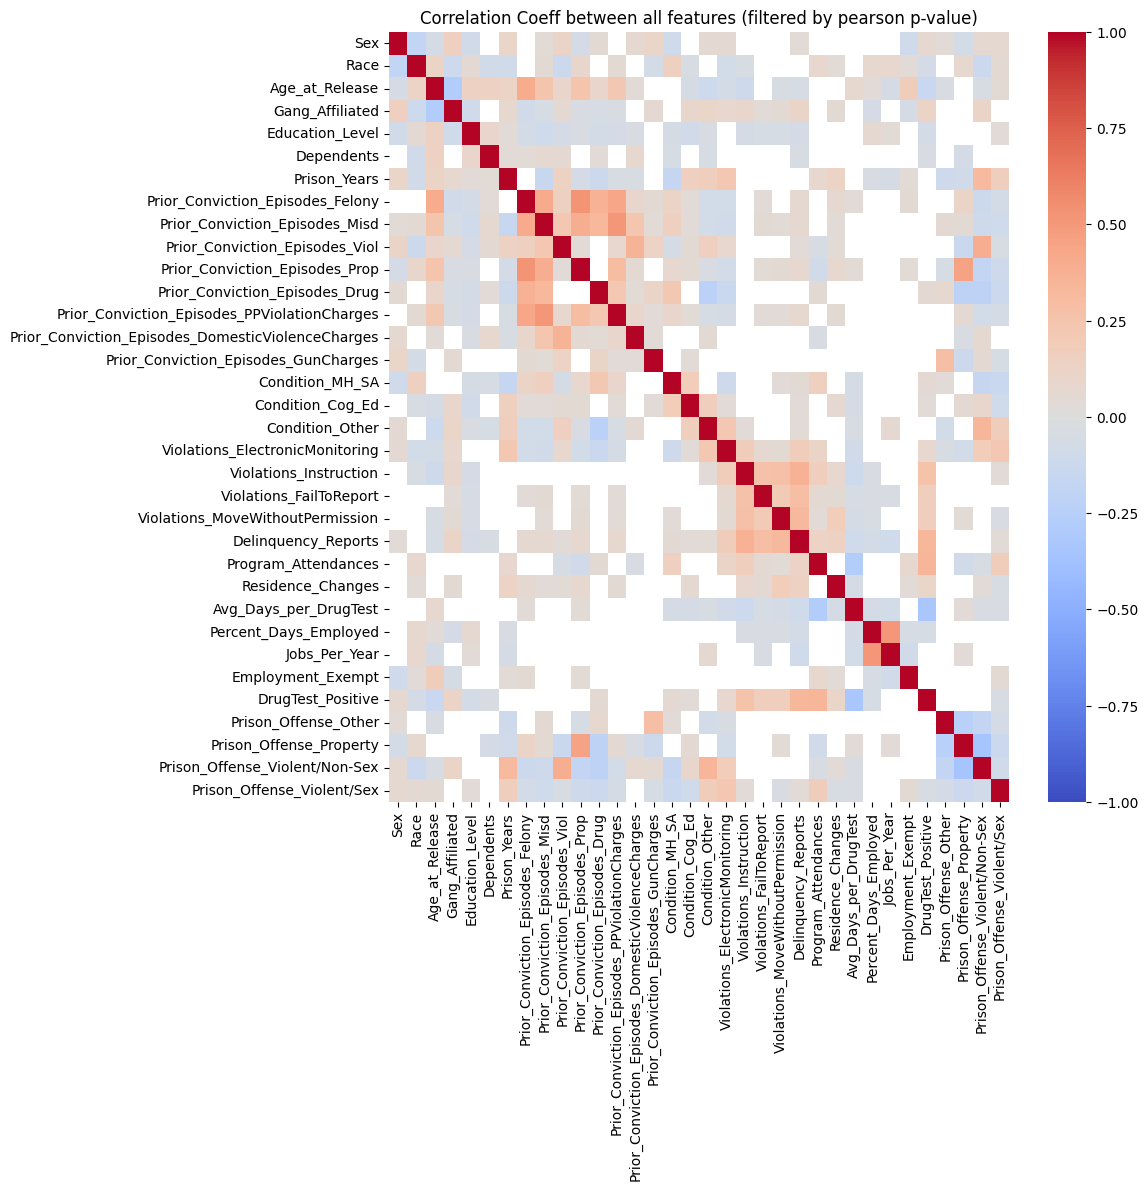

In [405]:
n_features = Xs_train.shape[1]
alpha = 0.05 # Significance level
corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

# Compute p-value using pearson
corr_pearson = np.zeros((n_features, n_features))
p = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_pearson[i,j], p[i,j] = pearsonr(Xs_train[:,i], Xs_train[:,j])
        if np.isnan(corr_pearson[i,j]):
            p[i,j] = 1

plt.figure(figsize=(10,10))
sns.heatmap(corr_pearson, vmin=-1, vmax=1, cmap="coolwarm", xticklabels=features, yticklabels=features, mask= p > corrected_alpha) ## mask if p is higher
plt.title("Correlation Coeff between all features (filtered by pearson p-value)")
plt.show()

We see quite a lot significant correlation, however many of which are numerically very small.

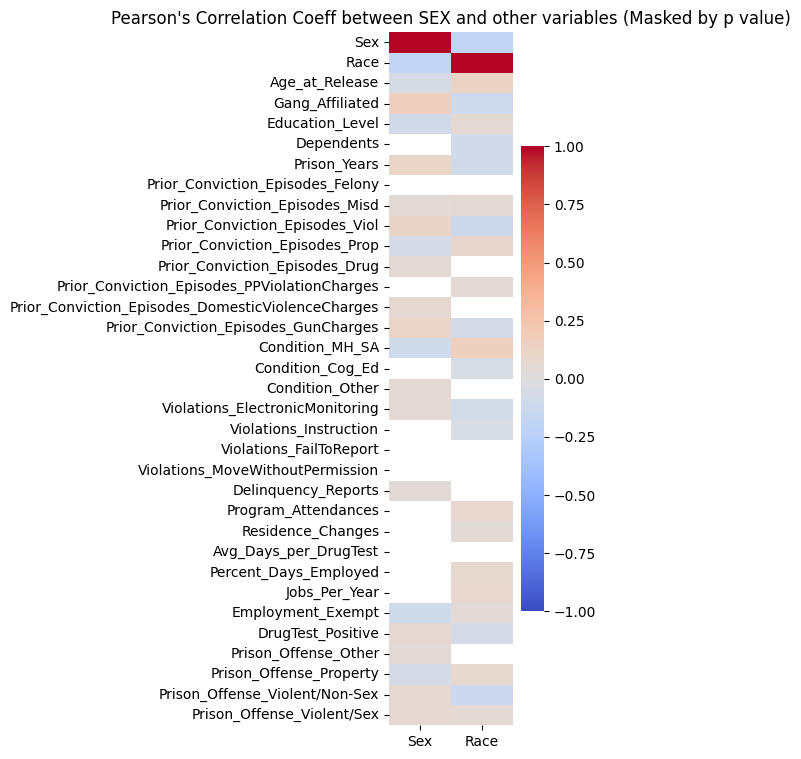

In [406]:
corr_pear = pd.DataFrame(corr_pearson, columns=features)
p_df = pd.DataFrame(p, columns=features, index=features)

plt.figure(figsize=(2,9))
sns.heatmap(corr_pear[['Sex','Race']], vmin=-1,vmax=1, cmap="coolwarm",  xticklabels=['Sex','Race'], yticklabels=features,  mask = (p_df > corrected_alpha)[['Sex','Race']].values) #)  & (corr_pear_cramer > 0.005))[['Sex','Race']], vmin=-0.25, vmax=0.25)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

## Model fitting

In [407]:
# Saving a training dataset without the protected features
Xs_train_none = np.delete(Xs_train, [0,1], axis=1)
Xs_val_none = np.delete(Xs_val, [0,1], axis=1)
Xs_test_none = np.delete(Xs_test, [0,1], axis=1)

Xs_train_protected = Xs_train[:, [0, 1]]
Xs_val_protected = Xs_val[:, [0, 1]]
Xs_test_protected = Xs_test[:, [0, 1]]

y_train=y_train.values
y_val=y_val.values
y_test=y_test.values


## Finetuning hyper parameters

In [408]:
# This code can be uncommented to calculate best hyperparameters
# Takes approx 10 minutes to run

# ## Logistic regression

# # Xs_train is dense (scaled) -> therefore solver is lbfgs
# # L2 for penalizing the SS of the weights 
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# grid_search_LR = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs'), param_grid, cv=5) #liblinear for binary 
# grid_search_LR.fit(Xs_train_none, y_train)  

# print("Best C:", grid_search_LR.best_params_['C'])
# print("Best score:", grid_search_LR.best_score_)
# C=grid_search_LR.best_params_['C']

# # Will produce this result:
# #C= 0.6795687135263339

# ## Random forest

# rf = RandomForestClassifier(random_state=33, n_jobs=-1)

# # Parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth':    [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf':  [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# # 5-fold CV grid search
# grid_search_RF = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',   # or another metric like 'roc_auc'
#     n_jobs=-1,
#     verbose=1
# )

# # Fit 
# grid_search_RF.fit(Xs_train_none, y_train)

# # Best combination
# print("Best params:", grid_search_RF.best_params_)
# print("Best CV score:", grid_search_RF.best_score_)

# # Will produce this result:
# # Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [409]:
group_val_dict = {
    'Male': groupsex_val == 'M',
    'Female': groupsex_val == 'F',
    'White': grouprace_val == 'WHITE',
    'Black':  grouprace_val == 'BLACK'
}

# Fit LR model
C= 0.6795687135263339 # from grid search
model = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
model.fit(Xs_train_none, y_train)
y_hatLR = model.predict(Xs_val_none.astype(float))


#Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
# Fit RF model
clf = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

clf.fit(Xs_train_none, y_train)
y_hatRF = clf.predict(Xs_val_none.astype(float))

# print('Logistic regression model')
# # Calculate and print F1 Scores for each group
# for group, group_idxs in group_val_dict.items():
#     print(f'F1, {group}: {f1_score(y_val[group_idxs], y_hatLR[group_idxs]):.2f}')

# # Calculate and print positive rates for each group
# for group, group_idxs in group_val_dict.items():
#     print(f'Positive Rate, {group}: {np.mean(y_hatLR[group_idxs]):.2f}')


# print('\nRandom forest model')
# # Calculate and print F1 Scores for each group
# for group, group_idxs in group_val_dict.items():
#     print(f'F1, {group}: {f1_score(y_val[group_idxs], y_hatRF[group_idxs]):.2f}')

# # Calculate and print positive rates for each group
# for group, group_idxs in group_val_dict.items():
#     print(f'Positive Rate, {group}: {np.mean(y_hatRF[group_idxs]):.2f}')

# Evaluating metrics

We have code to calculate precision, recall, specificity, fpr, fnr, accuracy and f1 score. This gave us a greater understanding on model performance, however in our report we will discuss the metrics, we find the most important.

In [410]:
# Calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, group_dict):
    metrics = []
    
    for group_name, group_idx in group_dict.items():
        group_cm = confusion_matrix(y_true[group_idx], y_pred[group_idx])
        
        # Extract values from confusion matrix
        if group_cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = group_cm.ravel()
            
            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            f1 = f1_score(y_true[group_idx], y_pred[group_idx])
            
            metrics.append({
                'Group': group_name,
                'Precision': precision,
                'Recall/TPR': tpr,
                'Specificity/TNR': tnr,
                'FPR': fpr,
                'FNR': fnr,
                'Accuracy': accuracy,
                'F1 Score': f1,
                'Group Size': sum(group_idx)
            })
    
    return pd.DataFrame(metrics)

In [411]:
# Calculate disparity between groups in metrics
def calculate_disparity(metrics_df):
    # Gender disparity (Male vs Female)
    gender_metrics = metrics_df.set_index(['Model', 'Group'])
    
    gender_disparity = []
    race_disparity = []
    
    for model in ['Logistic Regression', 'Random Forest']:
        # Calculate gender disparities
        if ('Male' in metrics_df['Group'].values) and ('Female' in metrics_df['Group'].values):
            male_metrics = gender_metrics.loc[(model, 'Male')]
            female_metrics = gender_metrics.loc[(model, 'Female')]
            
            for col in ['Precision', 'Recall/TPR', 'Specificity/TNR', 'FPR', 'FNR', 'Accuracy', 'F1 Score']:
                gender_disparity.append({
                    'Model': model,
                    'Comparison': 'Male vs Female',
                    'Metric': col,
                    'Male Value': male_metrics[col],
                    'Female Value': female_metrics[col],
                    'Absolute Difference': abs(male_metrics[col] - female_metrics[col]),
                    'Ratio': male_metrics[col] / female_metrics[col] if female_metrics[col] > 0 else float('inf')
                })
        
        # Calculate race disparities
        if ('White' in metrics_df['Group'].values) and ('Black' in metrics_df['Group'].values):
            white_metrics = gender_metrics.loc[(model, 'White')]
            black_metrics = gender_metrics.loc[(model, 'Black')]
            
            for col in ['Precision', 'Recall/TPR', 'Specificity/TNR', 'FPR', 'FNR', 'Accuracy', 'F1 Score']:
                race_disparity.append({
                    'Model': model,
                    'Comparison': 'White vs Black',
                    'Metric': col,
                    'White Value': white_metrics[col],
                    'Black Value': black_metrics[col],
                    'Absolute Difference': abs(white_metrics[col] - black_metrics[col]),
                    'Ratio': white_metrics[col] / black_metrics[col] if black_metrics[col] > 0 else float('inf')
                })
    
    return pd.DataFrame(gender_disparity), pd.DataFrame(race_disparity)

In [412]:
# Calculate metrics for both models
lr_metrics = calculate_fairness_metrics(y_val, y_hatLR, group_val_dict)
rf_metrics = calculate_fairness_metrics(y_val, y_hatRF, group_val_dict)

# Add model column to each DataFrame
lr_metrics['Model'] = 'Logistic Regression'
rf_metrics['Model'] = 'Random Forest'

# Combine in dataframe
all_metrics = pd.concat([lr_metrics, rf_metrics])

print("Fairness Metrics by Group and Model:")
print(all_metrics.round(3).to_string(index=False))

# Calculate disparities
gender_disparity_df, race_disparity_df = calculate_disparity(all_metrics)

# Display critical disparities (where absolute difference > 0.1)
print("\nNotable Sex Disparities (Absolute Difference > 0.1):")
notable_gender = gender_disparity_df[gender_disparity_df['Absolute Difference'] > 0.1]
if len(notable_gender) > 0:
    print(notable_gender[['Model', 'Metric', 'Male Value', 'Female Value', 'Absolute Difference']].round(3).to_string(index=False))
else:
    print("No notable gender disparities found.")

print("\nNotable Race Disparities (Absolute Difference > 0.1):")
notable_race = race_disparity_df[race_disparity_df['Absolute Difference'] > 0.1]
if len(notable_race) > 0:
    print(notable_race[['Model', 'Metric', 'White Value', 'Black Value', 'Absolute Difference']].round(3).to_string(index=False))
else:
    print("No notable race disparities found.")

# Display the most common misclassifications by group
print("\nMost Common Misclassifications by Group:")
for model_name, y_pred in [('Logistic Regression', y_hatLR), ('Random Forest', y_hatRF)]:
    print(f"\n{model_name}:")
    for group_name, group_idx in group_val_dict.items():
        group_y_true = y_val[group_idx]
        group_y_pred = y_pred[group_idx]
        
        # False positives
        fp_rate = ((group_y_pred == 1) & (group_y_true == 0)).sum() / (group_y_true == 0).sum() if (group_y_true == 0).sum() > 0 else 0
        
        # False negatives
        fn_rate = ((group_y_pred == 0) & (group_y_true == 1)).sum() / (group_y_true == 1).sum() if (group_y_true == 1).sum() > 0 else 0
        
        print(f"{group_name}: False Positive Rate: {fp_rate:.3f}, False Negative Rate: {fn_rate:.3f}")

Fairness Metrics by Group and Model:
 Group  Precision  Recall/TPR  Specificity/TNR   FPR   FNR  Accuracy  F1 Score  Group Size               Model
  Male      0.711       0.782            0.535 0.465 0.218     0.682     0.745        4513 Logistic Regression
Female      0.622       0.705            0.618 0.382 0.295     0.659     0.661         654 Logistic Regression
 White      0.704       0.751            0.580 0.420 0.249     0.677     0.727        2179 Logistic Regression
 Black      0.700       0.790            0.525 0.475 0.210     0.680     0.742        2988 Logistic Regression
  Male      0.707       0.816            0.506 0.494 0.184     0.690     0.758        4513       Random Forest
Female      0.603       0.724            0.575 0.425 0.276     0.645     0.658         654       Random Forest
 White      0.697       0.797            0.539 0.461 0.203     0.687     0.744        2179       Random Forest
 Black      0.695       0.813            0.501 0.499 0.187     0.683     0.

# Pre processing

In [413]:
# Function from exercise solution lecture 10
def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np

    # Return debiased nonprotected features
    return Xs_np_debiased

# Debiasing recidivism data
Xs_train_none_debiased = debias_features(Xs_train_none, Xs_train_protected)
Xs_train_debiased = np.concatenate([Xs_train_none_debiased, Xs_train_protected], axis=1)

In [414]:
C= 0.6795687135263339 # from grid search
model = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
model.fit(Xs_train_none_debiased, y_train)
y_hatLR_pre = model.predict(Xs_val_none.astype(float))


#Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
# Fit RF model
clf = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

clf.fit(Xs_train_none_debiased, y_train)
y_hatRF_pre = clf.predict(Xs_val_none.astype(float))

In [415]:


# Calculate metrics for both models
lr_metrics_pre = calculate_fairness_metrics(y_val, y_hatLR_pre, group_val_dict)
rf_metrics_pre = calculate_fairness_metrics(y_val, y_hatRF_pre, group_val_dict)

# Add model column to each DataFrame
lr_metrics_pre['Model'] = 'Logistic Regression'
rf_metrics_pre['Model'] = 'Random Forest'

# Combine the results
all_metrics_pre = pd.concat([lr_metrics, rf_metrics])

# Print the results
print("Fairness Metrics by Group and Model:")
print(all_metrics_pre.round(3).to_string(index=False))

# Calculate disparities
gender_disparity_df, race_disparity_df = calculate_disparity(all_metrics_pre)

# Display critical disparities (where absolute difference > 0.1)
print("\nNotable Gender Disparities (Absolute Difference > 0.1):")
notable_gender = gender_disparity_df[gender_disparity_df['Absolute Difference'] > 0.1]
if len(notable_gender) > 0:
    print(notable_gender[['Model', 'Metric', 'Male Value', 'Female Value', 'Absolute Difference']].round(3).to_string(index=False))
else:
    print("No notable gender disparities found.")

print("\nNotable Race Disparities (Absolute Difference > 0.1):")
notable_race = race_disparity_df[race_disparity_df['Absolute Difference'] > 0.1]
if len(notable_race) > 0:
    print(notable_race[['Model', 'Metric', 'White Value', 'Black Value', 'Absolute Difference']].round(3).to_string(index=False))
else:
    print("No notable race disparities found.")

# Display the most common misclassifications by group
print("\nMost Common Misclassifications by Group:")
for model_name, y_pred in [('Logistic Regression', y_hatLR), ('Random Forest', y_hatRF)]:
    print(f"\n{model_name}:")
    for group_name, group_idx in group_val_dict.items():
        group_y_true = y_val[group_idx]
        group_y_pred = y_pred[group_idx]
        
        # False positives
        fp_rate = ((group_y_pred == 1) & (group_y_true == 0)).sum() / (group_y_true == 0).sum() if (group_y_true == 0).sum() > 0 else 0
        
        # False negatives
        fn_rate = ((group_y_pred == 0) & (group_y_true == 1)).sum() / (group_y_true == 1).sum() if (group_y_true == 1).sum() > 0 else 0
        
        print(f"{group_name}: False Positive Rate: {fp_rate:.3f}, False Negative Rate: {fn_rate:.3f}")

Fairness Metrics by Group and Model:
 Group  Precision  Recall/TPR  Specificity/TNR   FPR   FNR  Accuracy  F1 Score  Group Size               Model
  Male      0.711       0.782            0.535 0.465 0.218     0.682     0.745        4513 Logistic Regression
Female      0.622       0.705            0.618 0.382 0.295     0.659     0.661         654 Logistic Regression
 White      0.704       0.751            0.580 0.420 0.249     0.677     0.727        2179 Logistic Regression
 Black      0.700       0.790            0.525 0.475 0.210     0.680     0.742        2988 Logistic Regression
  Male      0.707       0.816            0.506 0.494 0.184     0.690     0.758        4513       Random Forest
Female      0.603       0.724            0.575 0.425 0.276     0.645     0.658         654       Random Forest
 White      0.697       0.797            0.539 0.461 0.203     0.687     0.744        2179       Random Forest
 Black      0.695       0.813            0.501 0.499 0.187     0.683     0.

# Postprocessing

In [416]:
# Fit LR model 
C= 0.6795687135263339 # from grid search
model = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
model.fit(Xs_train_none, y_train)
probs_LR = model.predict_proba(Xs_val_none.astype(float))[:, 1]

# Fit RF model
clf = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

clf.fit(Xs_train_none, y_train) 
probs_RF = clf.predict_proba(Xs_test_none.astype(float))[:, 1]


# Protected attributes
protected_attr_test = Xs_val_protected

#  Logistic Regression
postproc_LR = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",  # 
    predict_method='predict_proba',
    prefit=True,
    flip=False # We don't want to flip(?)
)
postproc_LR.fit(Xs_val_none, y_val, sensitive_features=protected_attr_test)
y_hatLR_post = postproc_LR.predict(Xs_val_none, sensitive_features=protected_attr_test)

# Fairlearn Postprocessing: Random Forest 
postproc_RF = ThresholdOptimizer(
    estimator=clf,
    constraints="equalized_odds",  
    predict_method='predict_proba',
    prefit=True
)
postproc_RF.fit(Xs_val_none, y_val, sensitive_features=protected_attr_test)
y_hatRF_post = postproc_RF.predict(Xs_val_none, sensitive_features=protected_attr_test)


0    0.055101
1   -0.026012
2    0.013904
3    0.063505
Name: FPR, dtype: float64

In [418]:
# Calculate metrics for both models
lr_metrics_post = calculate_fairness_metrics(y_val, y_hatLR_post, group_val_dict)
rf_metrics_post = calculate_fairness_metrics(y_val, y_hatRF_post, group_val_dict)

# Add model column to each DataFrame
lr_metrics_post['Model'] = 'Logistic Regression'
rf_metrics_post['Model'] = 'Random Forest'

# Combine the results
all_metrics_post = pd.concat([lr_metrics, rf_metrics])

# Print the results
print("Fairness Metrics by Group and Model:")
print(all_metrics_post.round(3).to_string(index=False))

# Calculate disparities
gender_disparity_df, race_disparity_df = calculate_disparity(all_metrics_post)

# Display critical disparities (where absolute difference > 0.1)
print("\nNotable Gender Disparities (Absolute Difference > 0.1):")
notable_gender = gender_disparity_df[gender_disparity_df['Absolute Difference'] > 0.1]
if len(notable_gender) > 0:
    print(notable_gender[['Model', 'Metric', 'Male Value', 'Female Value', 'Absolute Difference']].round(3).to_string(index=False))
else:
    print("No notable gender disparities found.")

print("\nNotable Race Disparities (Absolute Difference > 0.1):")
notable_race = race_disparity_df[race_disparity_df['Absolute Difference'] > 0.1]
if len(notable_race) > 0:
    print(notable_race[['Model', 'Metric', 'White Value', 'Black Value', 'Absolute Difference']].round(3).to_string(index=False))
else:
    print("No notable race disparities found.")

# Display the most common misclassifications by group
print("\nMost Common Misclassifications by Group:")
for model_name, y_pred in [('Logistic Regression', y_hatLR_post), ('Random Forest', y_hatRF_post)]:
    print(f"\n{model_name}:")
    for group_name, group_idx in group_val_dict.items():
        group_y_true = y_test[group_idx]
        group_y_pred = y_pred[group_idx]
        
        # False positives
        fp_rate = ((group_y_pred == 1) & (group_y_true == 0)).sum() / (group_y_true == 0).sum() if (group_y_true == 0).sum() > 0 else 0
        
        # False negatives
        fn_rate = ((group_y_pred == 0) & (group_y_true == 1)).sum() / (group_y_true == 1).sum() if (group_y_true == 1).sum() > 0 else 0
        
        print(f"{group_name}: False Positive Rate: {fp_rate:.3f}, False Negative Rate: {fn_rate:.3f}")

Fairness Metrics by Group and Model:
 Group  Precision  Recall/TPR  Specificity/TNR   FPR   FNR  Accuracy  F1 Score  Group Size               Model
  Male      0.711       0.782            0.535 0.465 0.218     0.682     0.745        4513 Logistic Regression
Female      0.622       0.705            0.618 0.382 0.295     0.659     0.661         654 Logistic Regression
 White      0.704       0.751            0.580 0.420 0.249     0.677     0.727        2179 Logistic Regression
 Black      0.700       0.790            0.525 0.475 0.210     0.680     0.742        2988 Logistic Regression
  Male      0.707       0.816            0.506 0.494 0.184     0.690     0.758        4513       Random Forest
Female      0.603       0.724            0.575 0.425 0.276     0.645     0.658         654       Random Forest
 White      0.697       0.797            0.539 0.461 0.203     0.687     0.744        2179       Random Forest
 Black      0.695       0.813            0.501 0.499 0.187     0.683     0.

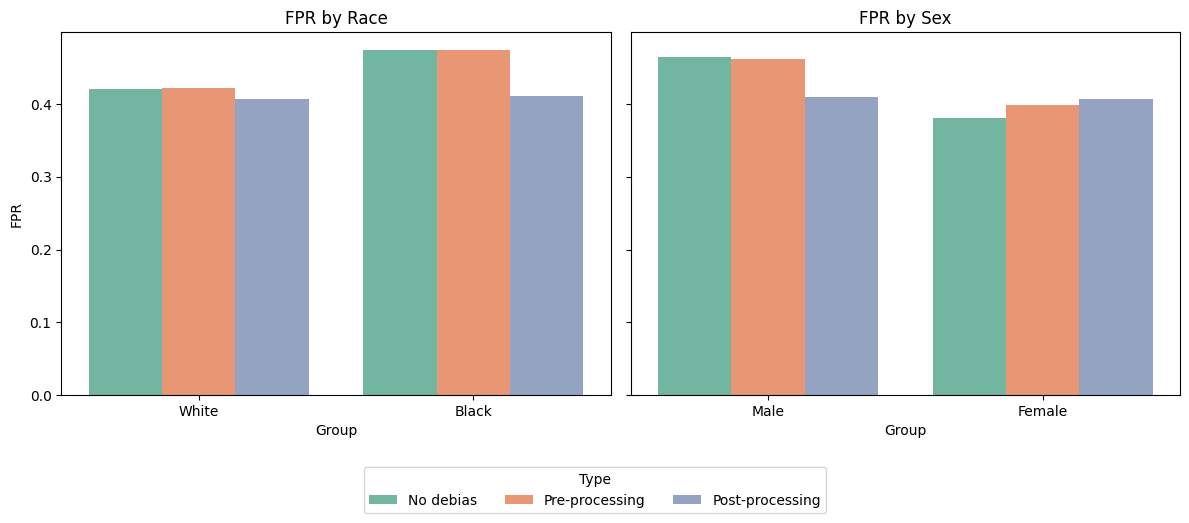

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Rename for clarity
lr_metrics['Type'] = 'No debias'
lr_metrics_pre['Type'] = 'Pre-processing'
lr_metrics_post['Type'] = 'Post-processing'

rf_metrics['Type'] = 'No debias'
rf_metrics_pre['Type'] = 'Pre-processing'
rf_metrics_post['Type'] = 'Post-processing'

# Combine all data
combined = pd.concat([lr_metrics, lr_metrics_pre, lr_metrics_post])

# Separate by group type
combined['GroupType'] = combined['Group'].apply(lambda x: 'Race' if x in ['White', 'Black'] else 'Sex')

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for Race
sns.barplot(data=combined[combined['GroupType'] == 'Race'], x='Group', y='FPR', hue='Type', ax=axes[0], palette='Set2')
axes[0].set_title('FPR by Race')

# Plot for Sex
sns.barplot(data=combined[combined['GroupType'] == 'Sex'], x='Group', y='FPR', hue='Type', ax=axes[1], palette='Set2')
axes[1].set_title('FPR by Sex')


# Remove legends from individual axes
axes[0].legend_.remove()
axes[1].legend_.remove()

# Extract legend handles/labels only once (from first axis)
handles, labels = axes[0].get_legend_handles_labels()

# Add shared legend at bottom
fig.legend(handles, labels, title='Type', loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))


plt.tight_layout()
plt.subplots_adjust(bottom=0.2) 
plt.show()


## Confusion matrices

In [419]:
# Confusion matrices
def plot_confusion_matrices(y_true, y_pred, group_dict, model_name):
    # Setup
    n_groups = len(group_dict) + 1  # +1 for the overall matrix
    fig, axes = plt.subplots(1, n_groups, figsize=(4*n_groups, 4))
    
    # Plot confusion matrix for all data 
    cm_all = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f'{model_name}: All Data')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    # Plot confusion matrix for each group
    for i, (group_name, group_idx) in enumerate(group_dict.items(), 1):
        cm_group = confusion_matrix(y_true[group_idx], y_pred[group_idx])
        sns.heatmap(cm_group, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'{model_name}: {group_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    plt.tight_layout()
    return fig

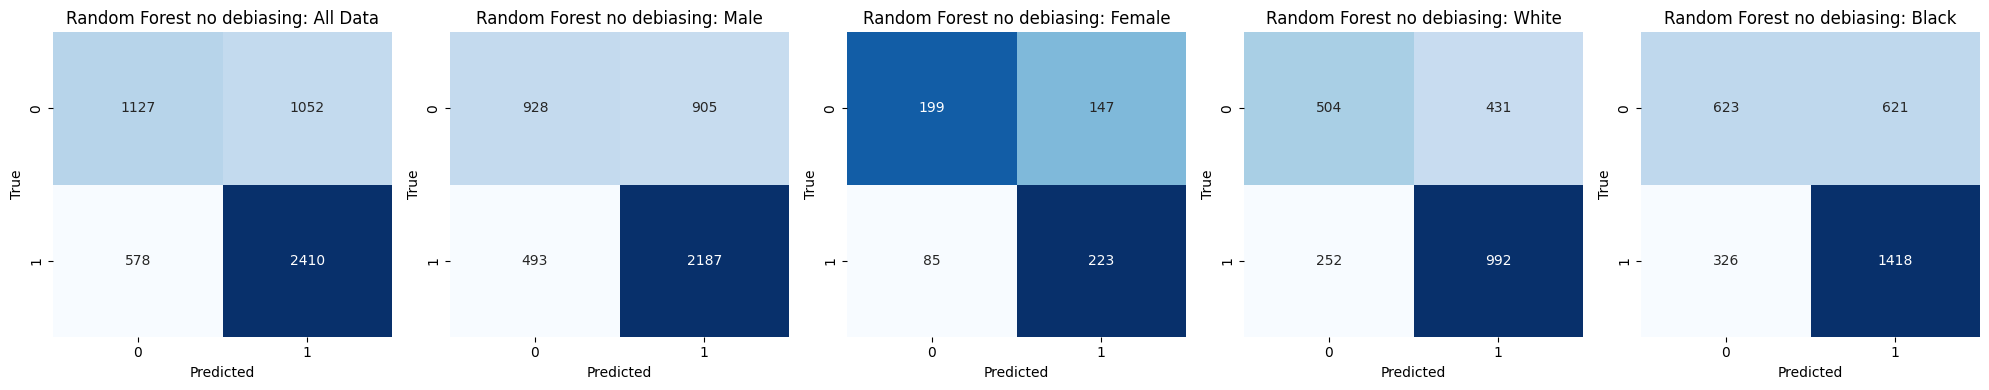

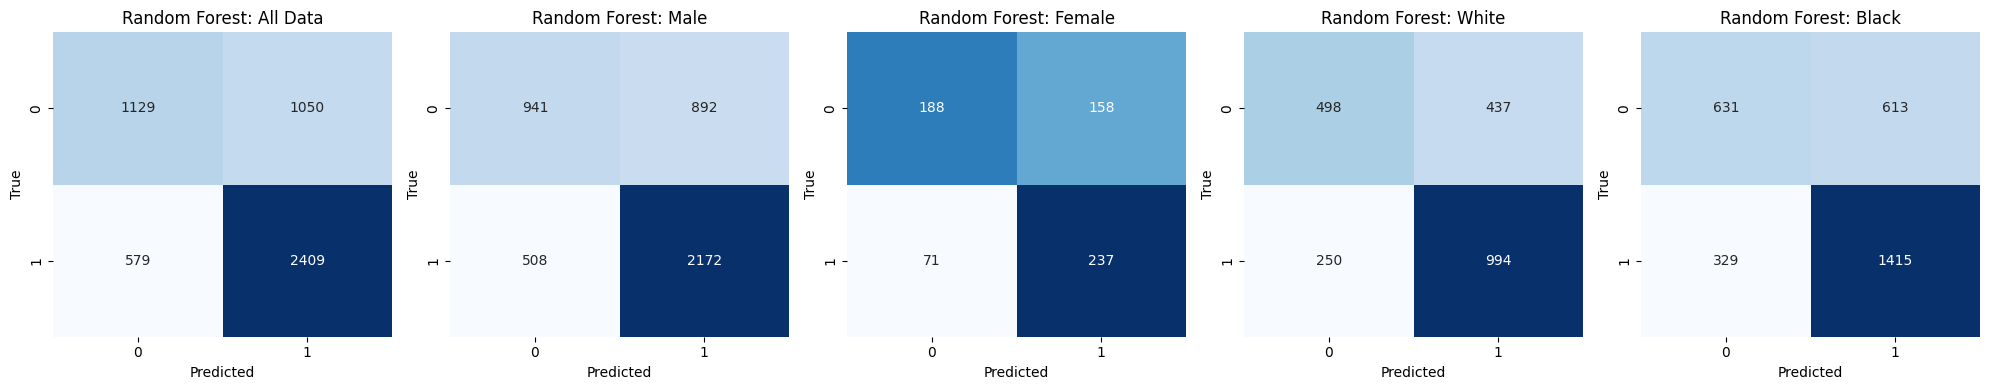

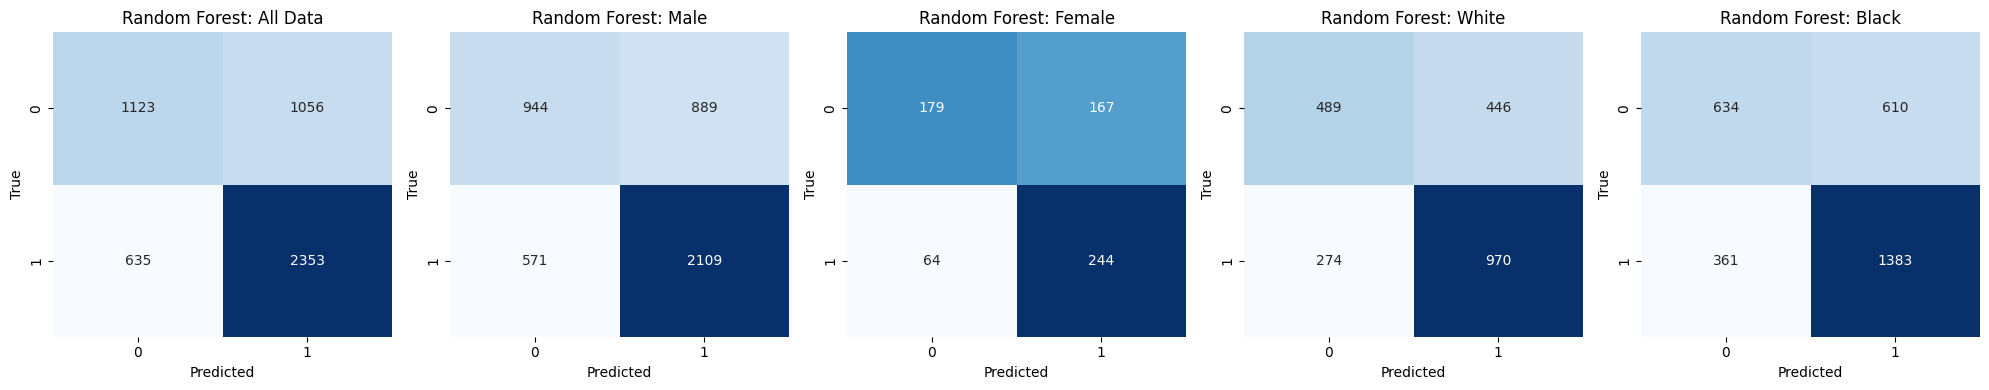

In [420]:
# Confusion matrices for Random Forest
fig_rf = plot_confusion_matrices(y_val, y_hatRF, group_val_dict, 'Random Forest no debiasing')


# Create confusion matrices for Random Forest
fig_rf = plot_confusion_matrices(y_val, y_hatRF_pre, group_val_dict, 'Random Forest')


# Create confusion matrices for Random Forest
fig_rf = plot_confusion_matrices(y_val, y_hatRF_post, group_val_dict, 'Random Forest')



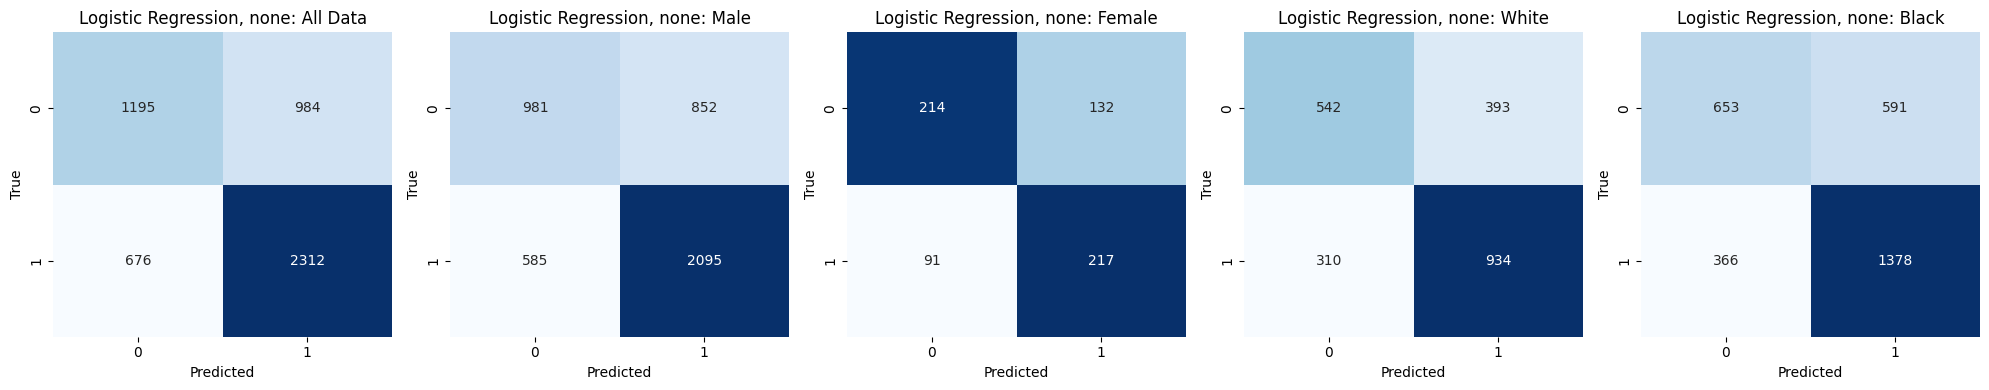

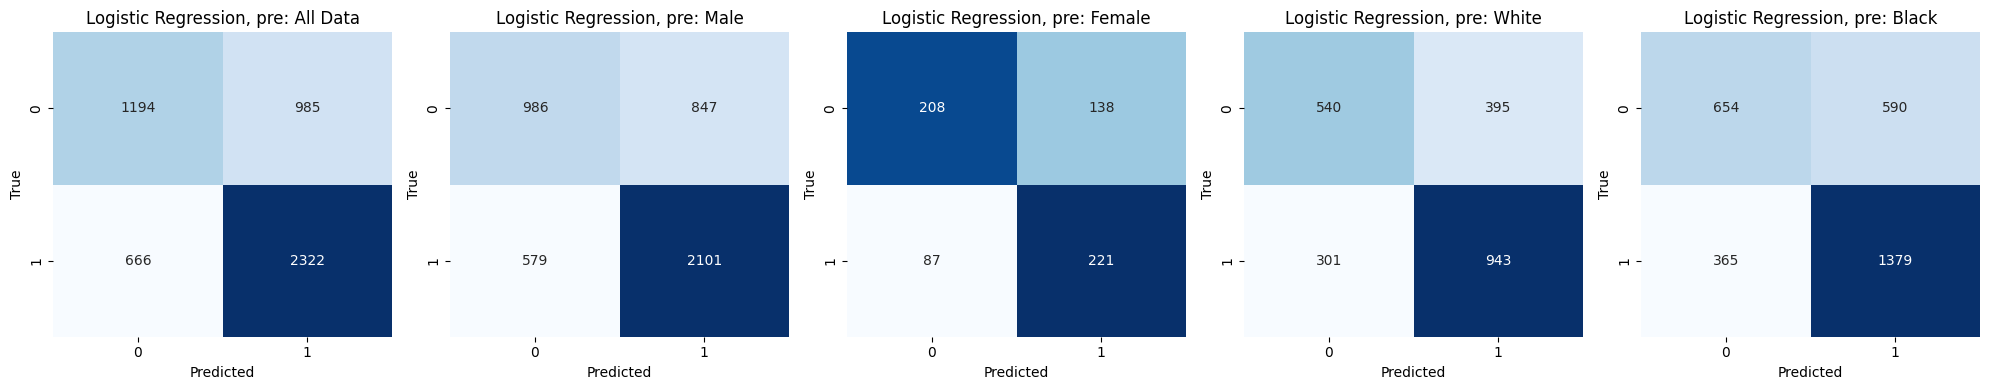

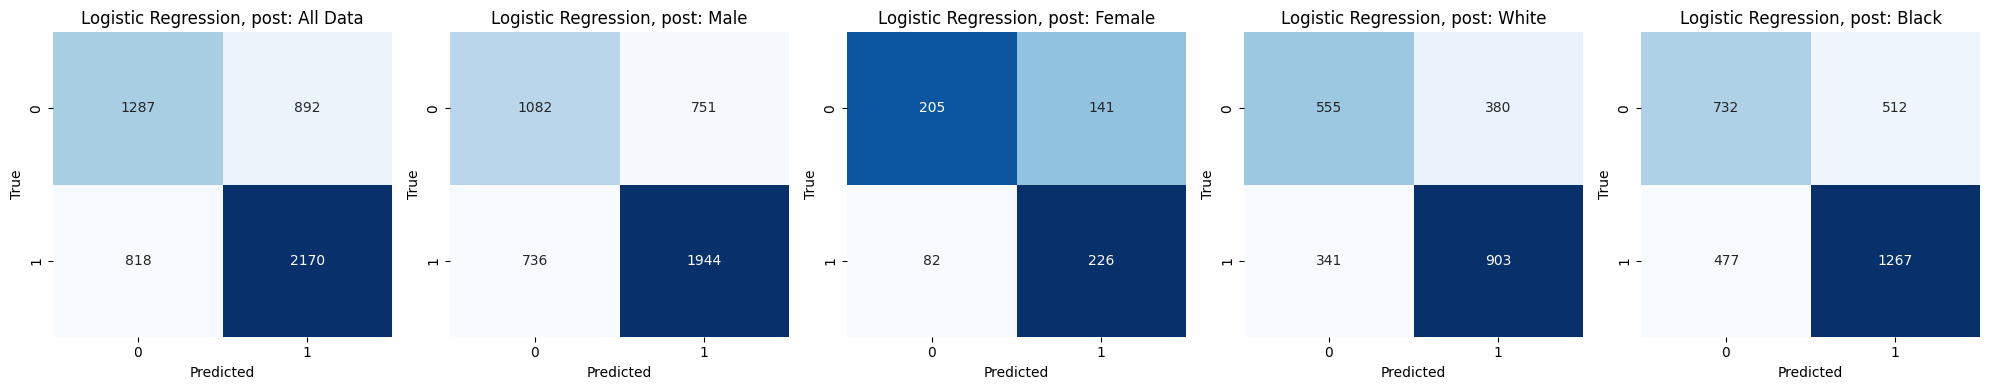

In [421]:
# Confusion matrices
def plot_confusion_matrices(y_true, y_pred, group_dict, model_name):
    # Setup
    n_groups = len(group_dict) + 1  # +1 for the overall matrix
    fig, axes = plt.subplots(1, n_groups, figsize=(4*n_groups, 4))
    
    # Plot confusion matrix for all data 
    cm_all = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f'{model_name}: All Data')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    # Plot confusion matrix for each group
    for i, (group_name, group_idx) in enumerate(group_dict.items(), 1):
        cm_group = confusion_matrix(y_true[group_idx], y_pred[group_idx])
        sns.heatmap(cm_group, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'{model_name}: {group_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    plt.tight_layout()
    return fig

# Confusion matrices for Logistic Regression
fig_lr = plot_confusion_matrices(y_val, y_hatLR, group_val_dict, 'Logistic Regression, none')
fig_lr = plot_confusion_matrices(y_val, y_hatLR_pre, group_val_dict, 'Logistic Regression, pre')
fig_lr = plot_confusion_matrices(y_val, y_hatLR_post, group_val_dict, 'Logistic Regression, post')
